# HANet for handover

This notebook is to show how to train HANet and visulize the grasping estimation.
Our network is a FCN whose backbone is ResNet1

In [ ]:
# default_exp model

In [ ]:
#hide
from nbdev.showdoc import *

In [4]:
# export 
import torch
import torch.nn as nn
import torchvision
import copy
import cv2
import sys
import numpy as np
from PIL import Image
from PIL import ImageDraw
import simplejson as json
from handover_grasping.utils import get_model

# Rosenberger
# ref:https://github.com/patrosAT/h2r_handovers
from rosenberger_utils.helper_ggcnn.ggcnn import predict
from rosenberger_utils.helper_ggcnn.pre_processing import Preparations

# DOPE
# ref:https://github.com/NVlabs/Deep_Object_Pose
sys.path.append('/home/arg/handover_grasping/DOPE_utils/train2')
sys.path.append('/home/arg/handover_grasping/DOPE_utils/train2/inference')
from cuboid import Cuboid3d
from cuboid_pnp_solver import CuboidPNPSolver
from detector import ModelData, ObjectDetector

class HANet(nn.Module):
    class FCN_model(nn.Module):
        def __init__(self, n_classes=4):
            super(HANet.FCN_model, self).__init__()
            self.color_trunk = torchvision.models.resnet101(pretrained=True)
            del self.color_trunk.fc, self.color_trunk.avgpool, self.color_trunk.layer4
            self.depth_trunk = copy.deepcopy(self.color_trunk)
            self.conv1 = nn.Conv2d(2048, 512, 1)
            self.conv2 = nn.Conv2d(512, 128, 1)
            self.conv3 = nn.Conv2d(128, n_classes, 1)
        def forward(self, color, depth):
            # Color
            color_feat_1 = self.color_trunk.conv1(color) # 3 -> 64
            color_feat_1 = self.color_trunk.bn1(color_feat_1)
            color_feat_1 = self.color_trunk.relu(color_feat_1)
            color_feat_1 = self.color_trunk.maxpool(color_feat_1)
            color_feat_2 = self.color_trunk.layer1(color_feat_1) # 64 -> 256
            color_feat_3 = self.color_trunk.layer2(color_feat_2) # 256 -> 512
            color_feat_4 = self.color_trunk.layer3(color_feat_3) # 512 -> 1024
            # Depth
            depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
            depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
            depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
            depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1)
            depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
            depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
            depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024
            # Concatenate
            feat = torch.cat([color_feat_4, depth_feat_4], dim=1) # 2048
            feat_1 = self.conv1(feat)
            feat_2 = self.conv2(feat_1)
            feat_3 = self.conv3(feat_2)
            return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)

    def __init__(self, pretrained=False, n_class=4):
        super(HANet, self).__init__()
        if pretrained == True:
            self.net = self.FCN_model(n_classes=4)
            model_path = get_model()
            self.net.load_state_dict(torch.load(model_path))
            print('Load pretrained complete')
        else:
            self.net = self.FCN_model(n_classes=n_class)

    def forward(self, Color, Depth):
        output = self.net(Color, Depth)

        return output
    
class HANet_depth(nn.Module):
    class FCN_model(nn.Module):
        def __init__(self, n_classes):
            super(HANet_depth.FCN_model, self).__init__()
            self.depth_trunk = torchvision.models.resnet101(pretrained=True)
            del self.depth_trunk.fc, self.depth_trunk.avgpool, self.depth_trunk.layer4

            self.conv1 = nn.Conv2d(1024, 512, 1)
            self.conv2 = nn.Conv2d(512, 128, 1)
            self.conv3 = nn.Conv2d(128, n_classes, 1)
        def forward(self, depth):
            # depth
            depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
            depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
            depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
            depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1) 
            depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
            depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
            depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024

            feat_1 = self.conv1(depth_feat_4)
            feat_2 = self.conv2(feat_1)
            feat_3 = self.conv3(feat_2)
            return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)

    def __init__(self, pretrained=False, n_class=4):
        super(HANet_depth, self).__init__()
        if pretrained == True:
            self.net = self.FCN_model(n_classes=4)
            model_path = get_model(True)
            self.net.load_state_dict(torch.load(model_path))
            print('Load pretrained complete')
        else:
            self.net = self.FCN_model(n_classes=n_class)

    def forward(self, Depth):
        output = self.net(Depth)

        return output

# ref:https://github.com/patrosAT/ggcnn_humanseg_ros/blob/master/src/helper_ggcnn/ggcnn.py   
class GGCNN():
    def __init__(self):
        self.prep = Preparations()
        self.scale = 300
        self.out_height = 480 
        self.out_width = 640
        
        
    def largest_indices(self, array, n):
        """Returns the n largest indices from a numpy array.
        
        This function return top-n index from given numpy array.
        
        Args:
            array (ndarray) : source array.
            n (int) : num of index to return.
            
        Returns:
            index
        
        """
        flat = array.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        
        return np.unravel_index(indices, array.shape)
    
    def angle_translater(self, angle, idx):
        """Remap angle.
        
        This function will get a specific index in pixel-wise angle numpy array and transfer from radius to degrees.
        
        Args:
            angle (ndarray) : angle in radius.
            idx (list) : target index of angle array.
            
        Returns:
            angle (degrees)
        
        """
        angle = (angle + np.pi/2) % np.pi - np.pi/2
        angle = angle[idx] *180/np.pi

        return angle

        
    def pred_grasp(self,depth, depth_nan, mask_body, mask_hand, bbox):
        """Get pixel-wise prediction result of grasping point and angle."""
        depth_bg, mask_bg = self.prep.prepare_image_mask(depth=depth, depth_nan=depth_nan, 
                                                    mask_body=mask_body, mask_hand=mask_hand, 
                                                    dist_obj=bbox[4], dist_ignore=1.0, 
                                                    grip_height=0.08)
        
        depth_ggcnn = cv2.resize(depth_bg,(self.scale,self.scale))
        mask_ggcnn = cv2.resize(mask_bg,(self.scale,self.scale))
        
        points, angle, width_img, _ = predict(depth=depth_ggcnn, mask=mask_ggcnn,
                                            crop_size=self.scale, out_size=self.scale, 
                                            crop_y_offset=40, filters=(2.0, 2.0, 2.0))
        
        return points, angle, width_img
    
    def get_grasp_pose(self, points, angle, width_img, top_n = 1):
        """Get Top-N prediction result
        
        This function will return top-n grasping parameter x, y, theta.
        
        Args:
            points (ndarray) : pixel-wise grasping point prediction by ggcnn.
            angle (ndarray) : pixel-wise grasping angle prediction by ggcnn.
            width_img (ndarray) : pixel-wise width_img prediction by ggcnn.
            top_n (int) : num of Top-N.
        
        Returns:
            list of Top-N result:[x, y, theta]
        """
        best_g = self.largest_indices(points, top_n)
        out_list = []
        for i in range(top_n):
            best_g_unr = (best_g[0][i], best_g[1][i])
            Angle = self.angle_translater(angle, best_g_unr)
            resize_point = [best_g_unr[0]*(self.out_height/self.scale), best_g_unr[1]*(self.out_width/self.scale)]
            
            x = int(resize_point[1])
            y = int(resize_point[0])
            theta = Angle
            
            out_list.append([x, y, theta])
            
        return out_list

# ref:https://github.com/andyzeng/arc-robot-vision
class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.color_trunk = torchvision.models.resnet101(pretrained=True)
        del self.color_trunk.fc, self.color_trunk.avgpool, self.color_trunk.layer4
        self.depth_trunk = copy.deepcopy(self.color_trunk)
        self.conv1 = nn.Conv2d(2048, 512, 1)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.conv3 = nn.Conv2d(128, n_classes, 1)
    def forward(self, color, depth):
        # Color
        color_feat_1 = self.color_trunk.conv1(color) # 3 -> 64
        color_feat_1 = self.color_trunk.bn1(color_feat_1)
        color_feat_1 = self.color_trunk.relu(color_feat_1)
        color_feat_1 = self.color_trunk.maxpool(color_feat_1) 
        color_feat_2 = self.color_trunk.layer1(color_feat_1) # 64 -> 256
        color_feat_3 = self.color_trunk.layer2(color_feat_2) # 256 -> 512
        color_feat_4 = self.color_trunk.layer3(color_feat_3) # 512 -> 1024
        # Depth
        depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
        depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
        depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
        depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1) 
        depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
        depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
        depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024
        # Concatenate
        feat = torch.cat([color_feat_4, depth_feat_4], dim=1) # 2048
        feat_1 = self.conv1(feat)
        feat_2 = self.conv2(feat_1)
        feat_3 = self.conv3(feat_2)
        return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)

    
# ref:https://github.com/NVlabs/Deep_Object_Pose/blob/master/scripts/train2/inference.py
class DopeNetwork(nn.Module):
    def __init__(
            self,
            numBeliefMap=9,
            numAffinity=16,
            stop_at_stage=6  # number of stages to process (if less than total number of stages)
        ):
        super(DopeNetwork, self).__init__()

        self.stop_at_stage = stop_at_stage

        vgg_full = models.vgg19(pretrained=False).features
        self.vgg = nn.Sequential()
        for i_layer in range(24):
            self.vgg.add_module(str(i_layer), vgg_full[i_layer])

        # Add some layers
        i_layer = 23
        self.vgg.add_module(str(i_layer), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1))
        self.vgg.add_module(str(i_layer+1), nn.ReLU(inplace=True))
        self.vgg.add_module(str(i_layer+2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1))
        self.vgg.add_module(str(i_layer+3), nn.ReLU(inplace=True))

        # print('---Belief------------------------------------------------')
        # _2 are the belief map stages
        self.m1_2 = DopeNetwork.create_stage(128, numBeliefMap, True)
        self.m2_2 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numBeliefMap, False)
        self.m3_2 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numBeliefMap, False)
        self.m4_2 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numBeliefMap, False)
        self.m5_2 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numBeliefMap, False)
        self.m6_2 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numBeliefMap, False)

        # print('---Affinity----------------------------------------------')
        # _1 are the affinity map stages
        self.m1_1 = DopeNetwork.create_stage(128, numAffinity, True)
        self.m2_1 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numAffinity, False)
        self.m3_1 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numAffinity, False)
        self.m4_1 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numAffinity, False)
        self.m5_1 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numAffinity, False)
        self.m6_1 = DopeNetwork.create_stage(128 + numBeliefMap + numAffinity,
                                             numAffinity, False)


    def forward(self, x):
        '''Runs inference on the neural network'''

        out1 = self.vgg(x)

        out1_2 = self.m1_2(out1)
        out1_1 = self.m1_1(out1)

        if self.stop_at_stage == 1:
            return [out1_2],\
                   [out1_1]

        out2 = torch.cat([out1_2, out1_1, out1], 1)
        out2_2 = self.m2_2(out2)
        out2_1 = self.m2_1(out2)

        if self.stop_at_stage == 2:
            return [out1_2, out2_2],\
                   [out1_1, out2_1]

        out3 = torch.cat([out2_2, out2_1, out1], 1)
        out3_2 = self.m3_2(out3)
        out3_1 = self.m3_1(out3)

        if self.stop_at_stage == 3:
            return [out1_2, out2_2, out3_2],\
                   [out1_1, out2_1, out3_1]

        out4 = torch.cat([out3_2, out3_1, out1], 1)
        out4_2 = self.m4_2(out4)
        out4_1 = self.m4_1(out4)

        if self.stop_at_stage == 4:
            return [out1_2, out2_2, out3_2, out4_2],\
                   [out1_1, out2_1, out3_1, out4_1]

        out5 = torch.cat([out4_2, out4_1, out1], 1)
        out5_2 = self.m5_2(out5)
        out5_1 = self.m5_1(out5)

        if self.stop_at_stage == 5:
            return [out1_2, out2_2, out3_2, out4_2, out5_2],\
                   [out1_1, out2_1, out3_1, out4_1, out5_1]

        out6 = torch.cat([out5_2, out5_1, out1], 1)
        out6_2 = self.m6_2(out6)
        out6_1 = self.m6_1(out6)

        return [out1_2, out2_2, out3_2, out4_2, out5_2, out6_2],\
               [out1_1, out2_1, out3_1, out4_1, out5_1, out6_1]

    @staticmethod
    def create_stage(in_channels, out_channels, first=False):
        '''Create the neural network layers for a single stage.'''

        model = nn.Sequential()
        mid_channels = 128
        if first:
            padding = 1
            kernel = 3
            count = 6
            final_channels = 512
        else:
            padding = 3
            kernel = 7
            count = 10
            final_channels = mid_channels

        # First convolution
        model.add_module("0",
                         nn.Conv2d(
                             in_channels,
                             mid_channels,
                             kernel_size=kernel,
                             stride=1,
                             padding=padding)
                        )

        # Middle convolutions
        i = 1
        while i < count - 1:
            model.add_module(str(i), nn.ReLU(inplace=True))
            i += 1
            model.add_module(str(i),
                             nn.Conv2d(
                                 mid_channels,
                                 mid_channels,
                                 kernel_size=kernel,
                                 stride=1,
                                 padding=padding))
            i += 1

        # Penultimate convolution
        model.add_module(str(i), nn.ReLU(inplace=True))
        i += 1
        model.add_module(str(i), nn.Conv2d(mid_channels, final_channels, kernel_size=1, stride=1))
        i += 1

        # Last convolution
        model.add_module(str(i), nn.ReLU(inplace=True))
        i += 1
        model.add_module(str(i), nn.Conv2d(final_channels, out_channels, kernel_size=1, stride=1))
        i += 1

        return model

# ref:https://github.com/NVlabs/Deep_Object_Pose/blob/master/scripts/train2/inference.py
class Draw(object):
    """Drawing helper class to visualize the neural network output"""

    def __init__(self, im):
        """
        :param im: The image to draw in.
        """
        self.draw = ImageDraw.Draw(im)

    def draw_line(self, point1, point2, line_color, line_width=2):
        """Draws line on image"""
        if point1 is not None and point2 is not None:
            self.draw.line([point1, point2], fill=line_color, width=line_width)

    def draw_dot(self, point, point_color, point_radius):
        """Draws dot (filled circle) on image"""
        if point is not None:
            xy = [
                point[0] - point_radius,
                point[1] - point_radius,
                point[0] + point_radius,
                point[1] + point_radius
            ]
            self.draw.ellipse(xy,
                              fill=point_color,
                              outline=point_color
                              )

    def draw_cube(self, points, color=(255, 0, 0)):
        """
        Draws cube with a thick solid line across
        the front top edge and an X on the top face.
        """

        # draw front
        self.draw_line(points[0], points[1], color)
        self.draw_line(points[1], points[2], color)
        self.draw_line(points[3], points[2], color)
        self.draw_line(points[3], points[0], color)

        # draw back
        self.draw_line(points[4], points[5], color)
        self.draw_line(points[6], points[5], color)
        self.draw_line(points[6], points[7], color)
        self.draw_line(points[4], points[7], color)

        # draw sides
        self.draw_line(points[0], points[4], color)
        self.draw_line(points[7], points[3], color)
        self.draw_line(points[5], points[1], color)
        self.draw_line(points[2], points[6], color)

        # draw dots
        self.draw_dot(points[0], point_color=color, point_radius=4)
        self.draw_dot(points[1], point_color=color, point_radius=4)

        # draw x on the top
        self.draw_line(points[0], points[5], color)
        self.draw_line(points[1], points[4], color)

# ref:https://github.com/NVlabs/Deep_Object_Pose/blob/master/scripts/train2/inference.py
class DopeNode(object):
    """ROS node that listens to image topic, runs DOPE, and publishes DOPE results"""
    def __init__(self,
            config, # config yaml loaded eg dict
        ):
        self.pubs = {}
        self.models = {}
        self.pnp_solvers = {}
        self.pub_dimension = {}
        self.draw_colors = {}
        self.dimensions = {}
        self.class_ids = {}
        self.model_transforms = {}
        self.meshes = {}
        self.mesh_scales = {}

        self.input_is_rectified = config['input_is_rectified']
        self.downscale_height = config['downscale_height']

        self.config_detect = lambda: None
        self.config_detect.mask_edges = 1
        self.config_detect.mask_faces = 1
        self.config_detect.vertex = 1
        self.config_detect.threshold = 0.5
        self.config_detect.softmax = 1000
        self.config_detect.thresh_angle = config['thresh_angle']
        self.config_detect.thresh_map = config['thresh_map']
        self.config_detect.sigma = config['sigma']
        self.config_detect.thresh_points = config["thresh_points"]

        # For each object to detect, load network model, create PNP solver, and start ROS publishers
        print(config['weights'])
        for model in config['weights']:
            print(model)
            self.models[model] = \
                ModelData(
                    model,
                    config['weights'][model],
                    architecture = config['architectures'][model]
                )
            self.models[model].load_net_model()
            print('loaded')

            try:
                self.draw_colors[model] = tuple(config["draw_colors"][model])
            except:
                self.draw_colors[model] = (0,255,0)
            self.dimensions[model] = tuple(config["dimensions"][model])
            self.class_ids[model] = config["class_ids"][model]

            self.pnp_solvers[model] = \
                CuboidPNPSolver(
                    model,
                    cuboid3d=Cuboid3d(config['dimensions'][model])
                )


        # print("Running DOPE...  (Listening to camera topic: '{}')".format(config['~topic_camera')))
        print("Ctrl-C to stop")

    def image_callback(self, 
        img, 
        camera_info, 
        img_name = "00000.png", # this is the name of the img file to save, it needs the .png at the end
        output_folder = 'out_inference', # folder where to put the output
        ):
        img_name = str(img_name).zfill(5)
        """Image callback"""

        # img = self.cv_bridge.imgmsg_to_cv2(image_msg, "rgb8")

        # cv2.imwrite('img.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # for debugging

        # Update camera matrix and distortion coefficients
        if self.input_is_rectified:
            P = np.matrix(camera_info['projection_matrix']['data'], dtype='float64').copy()
            P.resize((3, 4))
            camera_matrix = P[:, :3]
            dist_coeffs = np.zeros((4, 1))
        else:
            camera_matrix = np.matrix(camera_info.K, dtype='float64')
            camera_matrix.resize((3, 3))
            dist_coeffs = np.matrix(camera_info.D, dtype='float64')
            dist_coeffs.resize((len(camera_info.D), 1))

        # Downscale image if necessary
        height, width, _ = img.shape
        scaling_factor = float(self.downscale_height) / height
        if scaling_factor < 1.0:
            camera_matrix[:2] *= scaling_factor
            img = cv2.resize(img, (int(scaling_factor * width), int(scaling_factor * height)))

        for m in self.models:
            self.pnp_solvers[m].set_camera_intrinsic_matrix(camera_matrix)
            self.pnp_solvers[m].set_dist_coeffs(dist_coeffs)

        # Copy and draw image
        img_copy = img.copy()
        im = Image.fromarray(img_copy)
        draw = Draw(im)


        # dictionary for the final output
        dict_out = {"camera_data":{},"objects":[]}

        N = 0

        for m in self.models:
            # Detect object
            results, beliefs = ObjectDetector.detect_object_in_image(
                self.models[m].net,
                self.pnp_solvers[m],
                img,
                self.config_detect
            )
            # print(results)
            # print('---')
            # continue
            # Publish pose and overlay cube on image
            for i_r, result in enumerate(results):
                if result["location"] is None:
                    continue
                # print(result)
                loc = result["location"]
                ori = result["quaternion"]
                
                print(loc)

                dict_out['objects'].append({
                    'class':m,
                    'location':np.array(loc).tolist(),
                    'quaternion_xyzw':np.array(ori).tolist(),
                    'projected_cuboid':np.array(result['projected_points']).tolist(),
                })
                # print( dict_out )

                # transform orientation
                # TODO 
                # transformed_ori = tf.transformations.quaternion_multiply(ori, self.model_transforms[m])

                # rotate bbox dimensions if necessary
                # (this only works properly if model_transform is in 90 degree angles)
                # dims = rotate_vector(vector=self.dimensions[m], quaternion=self.model_transforms[m])
                # dims = np.absolute(dims)
                # dims = tuple(dims)

                # Draw the cube
                if None not in result['projected_points']:
                    points2d = []
                    for pair in result['projected_points']:
                        points2d.append(tuple(pair))
                    draw.draw_cube(points2d, self.draw_colors[m])
        # save the output of the image. 
        im.save(f"{output_folder}/{img_name}.png")

        # save the json files 
        with open(f"{output_folder}/{img_name}.json", 'w') as fp:
            json.dump(dict_out, fp)

# Inference

In [5]:
import cv2
from matplotlib import pyplot as plt
from handover_grasping.utils import get_grasp_line

## HANet Inference

### Import dependent libraries

In [18]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import  DataLoader
from handover_grasping.model import HANet
from handover_grasping.Datavisualizer import handover_grasping_dataset
from handover_grasping.utils import get_affordancemap

### Load Data

Do inference on HANet Testing datasets.

In [22]:
DATA_PATH = '/home/arg/handover_grasping/data/HANet_testing'

dataset = handover_grasping_dataset(DATA_PATH, mode='test', color_type='jpg')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 8)

### Initial HANet (with pre-trained weight)

Load HANet with pre-trained weight trained on HANet Training datasets.

In [20]:
net = HANet(pretrained=True)
net = net.cuda()
net.eval()

Load pretrained complete


HANet(
  (net): FCN_model(
    (color_trunk): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=

### Get sample data

In [23]:
batch = next(iter(dataloader))

color = batch['color'].cuda()
depth = batch['depth'].cuda()

depth_origin = batch['depth_origin'].cpu().detach().numpy()[0]
color_origin = batch['color_origin'].cpu().detach().numpy()[0]

### Prediction and Get Affordance Map

In [24]:
with torch.no_grad():
    predict = net(color, depth)
predict = predict.cpu().detach().numpy()

affordanceMap, x, y, theta = get_affordancemap(predict, depth_origin)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualize Prediction result

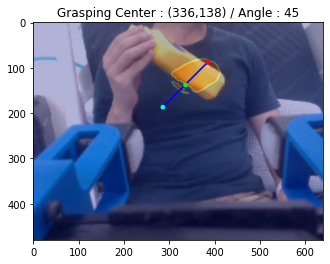

In [25]:
Combine = cv2.addWeighted(color_origin,0.7,affordanceMap, 0.3,0)
Result = cv2.resize(Combine, (640,480))
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)

point1, point2 = get_grasp_line(theta, [y, x], depth_origin)

Result = cv2.line(Result,point1,point2,(0,0,255),3)
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)
Result = cv2.circle(Result, point1, 5, (255,0,0), -1)
Result = cv2.circle(Result, point2, 5, (0,255,255), -1)

plt.imshow(Result)
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
plt.show()

## HANet Depth Inference

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
from torch.utils.data import  DataLoader
from handover_grasping.model import HANet_depth
from handover_grasping.Datavisualizer import handover_grasping_dataset
from handover_grasping.utils import get_affordancemap, get_grasp_line

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load Data

Do inference on HANet Easy Testing datasets.

In [24]:
DATA_PATH = '/home/arg/handover_grasping/data/HANet_easy_datasets'

dataset = handover_grasping_dataset(DATA_PATH, mode='test', color_type='jpg')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 8)

### Initial HANet (with pre-trained weight)

Load HANet_depth with pre-trained weight trained on HANet Training datasets.

In [3]:
net = HANet_depth(pretrained=True)
net = net.cuda()
net.eval()

Load pretrained complete


HANet_depth(
  (net): FCN_model(
    (depth_trunk): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

### Get sample data

In [31]:
batch = next(iter(dataloader))

color = batch['color'].cuda()
depth = batch['depth'].cuda()

depth_origin = batch['depth_origin'].cpu().detach().numpy()[0]
color_origin = batch['color_origin'].cpu().detach().numpy()[0]

### Prediction and Get Affordance Map

In [32]:
with torch.no_grad():
    predict = net(depth)
predict = predict.cpu().detach().numpy()

affordanceMap, x, y, theta = get_affordancemap(predict, depth_origin)

### Visualize Prediction result

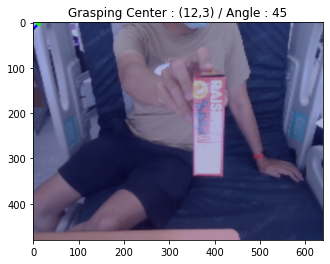

In [33]:
Combine = cv2.addWeighted(color_origin,0.7,affordanceMap, 0.3,0)
Result = cv2.resize(Combine, (640,480))
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)

point1, point2 = get_grasp_line(theta, [y, x], depth_origin)

Result = cv2.line(Result,point1,point2,(0,0,255),3)
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)
Result = cv2.circle(Result, point1, 5, (255,0,0), -1)
Result = cv2.circle(Result, point2, 5, (0,255,255), -1)

plt.imshow(Result)
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
plt.show()

## Rosenberger Inference
### ref:https://github.com/patrosAT/h2r_handovers

In [1]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
from handover_grasping.model import GGCNN

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load Data

Do inference on HANet Easy Testing datasets.

In [11]:
hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/HANet_easy_datasets')

### Initial GGCNN

Load ggcnn with pre-trained weight.

In [3]:
ggcnn = GGCNN()

### Get sample data

In [12]:
batch = hanet_easy_loader.get_next_data(vis_bbox=True)

color = batch['color']
color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
color_bbox = batch['color_bbox']
depth = batch['depth']
depth_nan = batch['depth_nan']
mask_hand = batch['mask_hand']
mask_body = batch['mask_body']
bbox = batch['bbox']

### Predict grasping pose by GGCNN

In [14]:
with torch.no_grad():
    points, angle, width_img = ggcnn.pred_grasp(depth, depth_nan, mask_body, mask_hand, bbox)
output = ggcnn.get_grasp_pose(points, angle, width_img)

### Prediction result : x, y, theta

In [15]:
output

[[332, 244, 1.1803659716049235]]

### Visualize prediction result

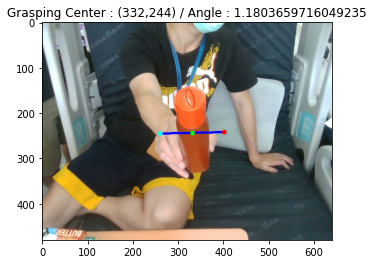

In [16]:
x = output[0][0]
y = output[0][1]
theta = output[0][2]

# to meter
depth_ = depth*1000.0

point1, point2 = get_grasp_line(theta, [y, x], depth_)

Result = cv2.line(color,point1,point2,(0,0,255),3)
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)
Result = cv2.circle(Result, point1, 5, (255,0,0), -1)
Result = cv2.circle(Result, point2, 5, (0,255,255), -1)

plt.imshow(Result)
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
plt.show()

## DOPE Inference
### ref:https://github.com/NVlabs/Deep_Object_Pose

In [2]:
from PIL import Image
from PIL import ImageDraw
import argparse
import yaml 
import glob
import os
import time
import sys
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models

from handover_grasping.model import DopeNetwork, Draw, DopeNode

### Set parameters

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--pause",
    default=0,
    help='pause between images')
parser.add_argument("--showbelief",
    action="store_true",
    help='show the belief maps')
parser.add_argument("--dontshow",
    action="store_true",
    help='headless mode')
parser.add_argument("--outf",
    default="out_experiment",
    help='where to store the output')
parser.add_argument("--data",
    default='*.png',
    help='folder for data images to load, *.png, *.jpeg, *jpg')
parser.add_argument("--config",
    default="/home/arg/handover_grasping/DOPE_utils/config/config_pose.yaml",
    help='folder for the inference configs')
parser.add_argument("--camera",
    default="/home/arg/handover_grasping/DOPE_utils/config/camera_info.yaml",
    help='camera info file')
parser.add_argument('--realsense',
    action='store_true',
    help='use the realsense camera')

opt = parser.parse_args([])

### Load config

In [4]:
with open(opt.config) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
with open(opt.camera) as f:
    camera_info = yaml.load(f, Loader=yaml.FullLoader)
    
if opt.realsense:
    import pyrealsense2 as rs
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)
    
print (f"output is located in {opt.outf}")
try:
    shutil.rmtree(f"{opt.outf}")
except:
    pass

try:
    os.makedirs(f"{opt.outf}")
except OSError:
    pass

output is located in out_experiment


### Load testing data and pre-trained weight

In [5]:
# load the images if there are some
path = '/home/arg/handover_grasping/data/Dope_testing'
f = open(path+'/test.txt', "r")
imgs = []
imgsname = []
for i, line in enumerate(f):
    id = line.replace("\n", "")
    imgs.append(path+'/color/color_'+id+'.png')
    imgsname.append('color_'+id)

if not opt.data is None:
    videopath = opt.data
    for j in sorted(glob.glob(videopath+"/*.png")):
        imgs.append(j)
        imgsname.append(j.replace(videopath,"").replace("/",""))
else:
    if not opt.realsense:
        cap = cv2.VideoCapture(0)

# An object to run dope node
dope_node = DopeNode(config)

{'Spaghetti': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Spaghetti.pth', 'mustard': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/mustard_60.pth', 'Butter': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Butter.pth', 'BBQSauce': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/BBQSauce.pth', 'Mayo': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Mayo.pth', 'Popcorn': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Popcorn.pth', 'soup': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/soup_60.pth', 'Raisins': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Raisins.pth', 'ChocolatePudding': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/ChocolatePudding.pth', 'sugar': '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/sugar_60.pth'}
Spaghetti
Loading DOPE model '/home/arg/handover_grasping/DOPE_utils/pretrained_weight/Spaghetti.pth'...
    Model loaded in 4.734270811080933 seconds.
lo

### Make Prediction

frame color_17


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


[-11.373858467753646, 1.0299167815763317, 50.87797949183864]
[10.742235518999625, 0.3805561312728738, 47.89290718632883]


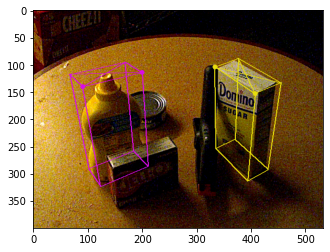

In [13]:
frame = cv2.imread(imgs[17])
print(f"frame {imgsname[17]}")
img_name = imgsname[17]

frame = frame[...,::-1].copy()

# call the inference node
dope_node.image_callback(
frame, 
camera_info,
img_name = img_name,
output_folder = opt.outf)

result = cv2.imread('/home/arg/handover_grasping/out_experiment/color_17.png')
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()

## ConvNet Inference
### ref:https://github.com/andyzeng/arc-robot-vision

In [1]:
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import  DataLoader
from handover_grasping.Datavisualizer import parallel_jaw_based_grasping_dataset
from handover_grasping.utils import get_grasp_line, get_affordancemap, Image_table
from handover_grasping.model import ConvNet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load data

Do inference on parallel-jaw-grasping-dataset.

In [2]:
dataset = parallel_jaw_based_grasping_dataset('/home/arg/handover_grasping/data/parallel-jaw-grasping-dataset', use_zeng=True)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 1)

### Initial ConvNet with pre-trained weight

Load ConvNet with pre-trained weight trained on parallel-jaw-grasping-dataset.

In [3]:
net = ConvNet(3)
net = net.cuda()
net.load_state_dict(torch.load('/home/arg/handover_grasping/model/baseline-graspnet.pth'))
net.eval()

ConvNet(
  (color_trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

### Get sample data

In [4]:
batch = next(iter(dataloader))

# RGB and Depth image list, each contain 16 images
colors = batch['color']
depths = batch['depth']

colors_origin = batch['color_origin']
depths_origin = batch['depth_origin']

### Make prediction

This cell will rotate input images 15 times and do inference, this is to find the object angle by select the maximum prediction value of 16 predictions.

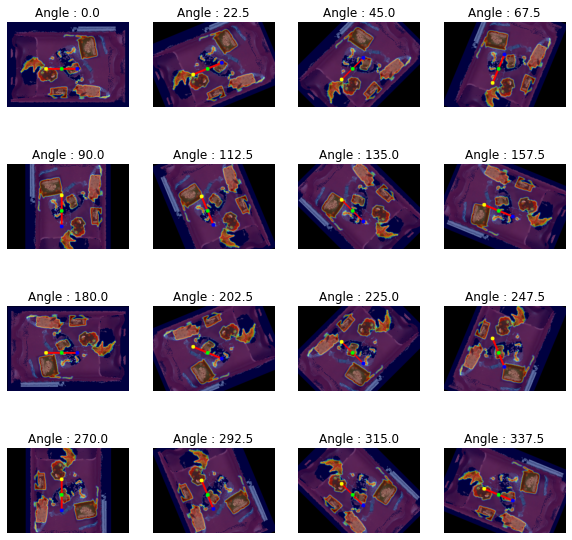

In [7]:
aff_list = []
title_list = []
value_list = []
coord_list = []
for i in range(16):
    color = colors[i].cuda()
    depth = depths[i].cuda()
    
    with torch.no_grad():
        predict = net.forward(color, depth)
        
    Depth = depths_origin[0][0].numpy()
    
    value = np.max(predict[0,2].cpu().numpy())

    affordanceMap, x, y = get_affordancemap(predict, Depth, True)

    color = colors_origin[i][0].numpy().astype('uint8')

    center = (int(color.shape[1]/2), int(color.shape[0]/2))
    M = cv2.getRotationMatrix2D(center, i*22.5, 1.0)
    affordanceMap = cv2.warpAffine(affordanceMap, M, (color.shape[1], color.shape[0]))
    
    value_list.append(value)

    Combine = cv2.addWeighted(color,0.5,affordanceMap, 0.5,0)
    
    theta = i*22.5

    point1, point2 = get_grasp_line(theta, [y, x], Depth)

    Combine = cv2.line(Combine,point1,point2,(0,0,255),3)
    Combine = cv2.circle(Combine, (int(x), int(y)), 5, (0,255,0), -1)
    Combine = cv2.circle(Combine, point1, 5, (255,0,0), -1)
    Combine = cv2.circle(Combine, point2, 5, (0,255,255), -1)
    
    aff_list.append(Combine[:,:,[2,1,0]])
    title_list.append('Angle : '+str(i*22.5))
    coord_list.append([x, y])

# show result
Image_table(4,4,aff_list,title_list)

### Select Max angle
Select the maximum prediction value from 16 predictions to find the object angle

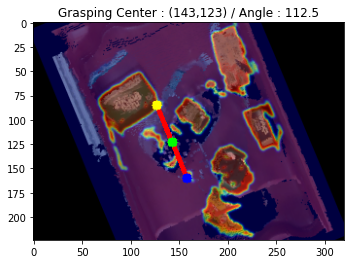

In [8]:
max_id = value_list.index(max(value_list))
x = coord_list[max_id][0]
y = coord_list[max_id][1]
plt.imshow(aff_list[max_id])
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, max_id*22.5))
plt.show()